In [3]:
import sys
sys.path.append('/home/t/tingli/tingli/pythoncode/')

import sqlutilpy
import dustmaps.sfd
SFD=dustmaps.sfd.SFDQuery()
import matplotlib.pyplot as plt
import sphdist
import sphere_rotate
import numpy as np
import matplotlib.pyplot as plt
import code_astro
from start_plot import *
plt.rcParams['figure.figsize']=[5,5]
def betw(x,x1,x2): return (x>x1)&(x<x2)
from idlplot import tvhist2d
from astropy import table

In [96]:
ra0,dec0=229.022083, -0.11138
rad0 =1.6

pal5rapol = 138.95
pal5decpol = 53.78
pal5ra_ref = 229
ra_cen,dec_cen=sphere_rotate.sphere_rotate(1,0,pal5rapol,pal5decpol,pal5ra_ref,revert=True)

string = '''select release, brickid, brickname, objid, type, ra, dec, ebv, flux_g, flux_r, flux_z, flux_ivar_g,flux_ivar_r,flux_ivar_z \
from decals_dr9.main where q3c_radial_query(ra,dec,%f,%f,%f)'''%(ra_cen,dec_cen, rad0)
t = sqlutilpy.get(string, asDict = True) 
t = table.Table(t)
t['gmag'], t['rmag'], t['zmag'] = [22.5-2.5*np.log10(t['flux_'+_]) for _ in 'grz']

#correct for extinction using ebv from sfd98, from DES DR2
t['gmag0'] = t['gmag'] - t['ebv'] * 3.186
t['rmag0'] = t['rmag'] - t['ebv'] * 2.140
t['zmag0'] = t['zmag'] - t['ebv'] * 1.196
t['gmagerr'], t['rmagerr'], t['zmagerr'] = [2.5/np.log(10)*(np.sqrt(1./t['flux_ivar_'+_])/t['flux_'+_]) for _ in 'grz']

dm1 = code_astro.d2dm(21.94)
t['dist1'] = sphdist.sphdist(t['ra'],t['dec'],ra0,dec0)

dm2 = code_astro.d2dm(7.48)
ra2,dec2 = 229.638, 2.081
t['dist2'] = sphdist.sphdist(t['ra'],t['dec'],ra2,dec2)


/tmp/ipykernel_241432/4001384220.py:13: RuntimeWarning: divide by zero encountered in log10
  t['gmag'], t['rmag'], t['zmag'] = [22.5-2.5*np.log10(t['flux_'+_]) for _ in 'grz']
/tmp/ipykernel_241432/4001384220.py:13: RuntimeWarning: invalid value encountered in log10
  t['gmag'], t['rmag'], t['zmag'] = [22.5-2.5*np.log10(t['flux_'+_]) for _ in 'grz']
/tmp/ipykernel_241432/4001384220.py:19: RuntimeWarning: divide by zero encountered in true_divide
  t['gmagerr'], t['rmagerr'], t['zmagerr'] = [2.5/np.log(10)*(np.sqrt(1./t['flux_ivar_'+_])/t['flux_'+_]) for _ in 'grz']


/tmp/ipykernel_241432/3587840203.py:2: RuntimeWarning: invalid value encountered in log10
  ydata = np.log10(t['rmagerr'])


Text(0, 0.5, 'log10(rmagerr)')

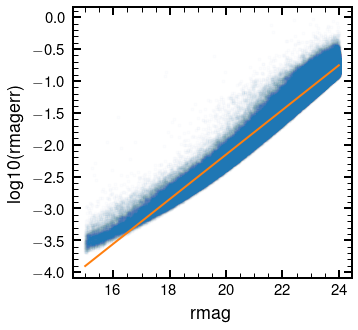

In [168]:
xdata = t['rmag']
ydata = np.log10(t['rmagerr'])
xnew = xdata[betw(xdata, 15,24)&betw(ydata,-4,0)]
ynew = ydata[betw(xdata, 15,24)&betw(ydata,-4,0)]

plt.plot(xnew, ynew,'.',alpha=0.01)

def log10_error_func(x, a, b):
    return a * x + b

from scipy.optimize import curve_fit
popt, pcov = curve_fit(log10_error_func, xnew, ynew)

xdata = np.linspace(15,24,100)
plt.plot(xdata, log10_error_func(xdata, *popt))
plt.xlabel('rmag')
plt.ylabel('log10(rmagerr)')

Text(0.5, 0, 'ra')

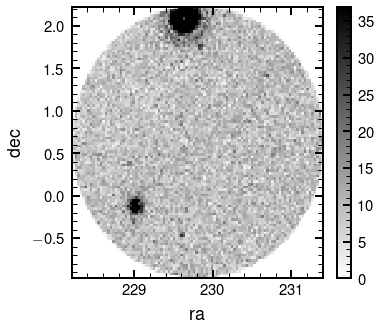

In [98]:
ind= (t['type'] == 'PSF') & (t['rmag']<22.5) & (t['rmag']>19)
tvhist2d(t['ra'][ind],t['dec'][ind],bar=True, vmaxfrac=.99)
plt.ylabel('dec')
plt.xlabel('ra')

Text(0.5, 0, 'gmag0-rmag0')

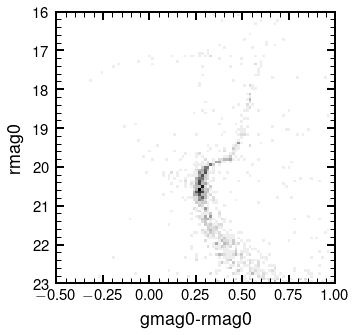

In [99]:
ind= (t['dist1']<0.1) & (t['type'] == 'PSF') 
tvhist2d(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],-0.5,1.0,23,16)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')

Text(0.5, 0, 'gmag0-rmag0')

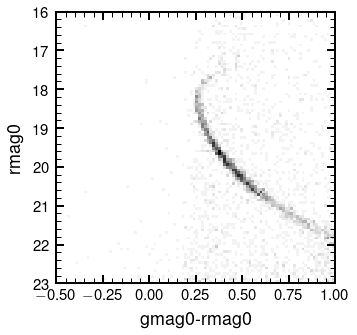

In [100]:
ind= (t['dist2']>0.2) & (t['dist2']<0.4) & (t['type'] == 'PSF') 
tvhist2d(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],-0.5,1.0,23,16)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')

In [101]:
isofile_mp = '/home/t/tingli/tingli/data/isochrones/dotter/iso_a12.5_z0.00010.dat'
dotter_mp = np.loadtxt(isofile_mp)
dotter_g_mp = dotter_mp[:,6]
dotter_r_mp = dotter_mp[:,7]

isofile_mr = '/home/t/tingli/tingli/data/isochrones/dotter/iso_a10.0_z0.00108.dat'
dotter_mr = np.loadtxt(isofile_mr)
dotter_g_mr = dotter_mr[:,6]
dotter_r_mr = dotter_mr[:,7]

dm_m92_harris = 14.59
m92ebv = 0.023
m92ag = m92ebv * 3.184
m92ar = m92ebv * 2.130
m92_hb_r = np.array([17.3, 15.8, 15.38, 15.1, 15.05, 15.05])
m92_hb_col = np.array([-0.39, -0.3, -0.2, -0.0, 0.1,0.2])
m92_hb_g = m92_hb_r + m92_hb_col
des_m92_hb_g = m92_hb_g - 0.104 * (m92_hb_g - m92_hb_r) + 0.01
des_m92_hb_r = m92_hb_r - 0.102 * (m92_hb_g - m92_hb_r) + 0.02
des_m92_hb_g = des_m92_hb_g - m92ag - dm_m92_harris
des_m92_hb_r = des_m92_hb_r - m92ar - dm_m92_harris


Text(0.5, 0, 'gmag0-rmag0')

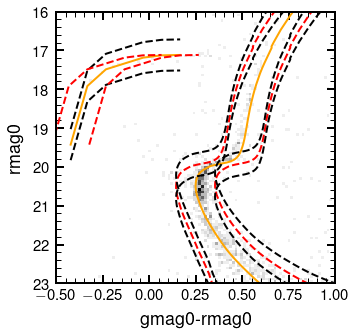

In [102]:
dotter_g, dotter_r = dotter_g_mr,dotter_r_mr
grw = np.sqrt(0.1**2 + (3*10**log10_error_func(dotter_r+dm1, *popt))**2)

ind= (t['dist1']<0.1) & (t['type'] == 'PSF') 
tvhist2d(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],-0.5,1.0,23,16)

plt.plot(dotter_g-dotter_r, dotter_r+dm1,lw=2,color='orange')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1+0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1+0.3,'--k')

plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1, lw=2, color='orange')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1-0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1+0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm1,'--r')
plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm1,'--r')

plt.ylim(23, 16)
plt.xlim(-0.5,1)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')

In [103]:
# making actual selections/cuts -- CMD cut and color-color cut

# CMD cut for RGB
def cmd_selection(t, dm, dotter_g, dotter_r, gw=0.3):
    grw = np.sqrt(0.1**2 + (3*10**log10_error_func(dotter_r+dm, *popt))**2)
    gw = gw # RGB width in g
    rmin = 16
    rmax = 23
    grmin = -0.5
    grmax = 1.0
    magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
    gr = t['gmag0'] - t['rmag0']
    grmax1 = np.interp(t['rmag0'], dotter_r[::-1] + dm, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax2 = np.interp(t['rmag0'], dotter_r[::-1] + dm + gw, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax3 = np.interp(t['rmag0'], dotter_r[::-1] + dm - gw, dotter_g[::-1] - dotter_r[::-1]+grw[::-1], left=np.nan, right=np.nan)
    grmax = np.max(np.array([grmax1, grmax2, grmax3]), axis=0)
    grmin1 = np.interp(t['rmag0'], dotter_r[::-1] + dm, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin2 = np.interp(t['rmag0'], dotter_r[::-1] + dm - gw, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin3 = np.interp(t['rmag0'], dotter_r[::-1] + dm + gw, dotter_g[::-1] - dotter_r[::-1]-grw[::-1], left=np.nan, right=np.nan)
    grmin = np.min(np.array([grmin1, grmin2, grmin3]), axis=0)
    colorsel = (gr < grmax) & (gr > grmin)
    colorrange = magrange & colorsel

    # CMD cut for BHB
    grw_bhb = 0.1 # BHB width in gr
    gw_bhb = 0.4  # BHB width in g
    grmin_bhb = -0.5
    grmax_bhb = 0.2
    magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)

    gr_bhb = np.interp(t['rmag0'], des_m92_hb_r[::-1] + dm , des_m92_hb_g[::-1] - des_m92_hb_r[::-1], left=np.nan, right=np.nan)
    rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
    del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb
    del_g_cmd_bhb = t['rmag0'] - rr_bhb
    colorrange_bhb = magrange_bhb & ((abs(del_color_cmd_bhb) < grw_bhb) | (abs(del_g_cmd_bhb) < gw_bhb))

    colorrange = colorrange | colorrange_bhb
    
    return colorrange


/tmp/ipykernel_241432/1467120447.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
/tmp/ipykernel_241432/1467120447.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']
/tmp/ipykernel_241432/1467120447.py:29: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)
/tmp/ipykernel_241432/1467120447.py:32: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
/tmp/ipykernel_241432/1467120447.py:33: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb


Text(0.5, 0, 'gmag0-rmag0')

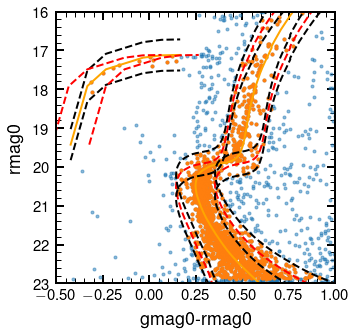

In [104]:
colorrange = cmd_selection(t, dm1, dotter_g, dotter_r)

ind= (t['dist1']<0.2) & (t['type'] == 'PSF') 
plt.plot(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],'.', alpha=0.5)
plt.plot(t['gmag0'][ind&colorrange]-t['rmag0'][ind&colorrange],t['rmag0'][ind&colorrange], '.')

plt.plot(dotter_g-dotter_r, dotter_r+dm1,lw=2,color='orange')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1,'--r')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1+0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r+grw, dotter_r+dm1-0.3,'--k')
plt.plot(dotter_g-dotter_r-grw, dotter_r+dm1+0.3,'--k')

plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1, lw=2, color='orange')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1-0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm1+0.4,'--k')
plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm1,'--r')
plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm1,'--r')


plt.ylim(23, 16)
plt.xlim(-0.5,1)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')

/tmp/ipykernel_241432/1467120447.py:11: RuntimeWarning: invalid value encountered in subtract
  magrange = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax) & (t['gmag0'] - t['rmag0'] > grmin)
/tmp/ipykernel_241432/1467120447.py:12: RuntimeWarning: invalid value encountered in subtract
  gr = t['gmag0'] - t['rmag0']
/tmp/ipykernel_241432/1467120447.py:29: RuntimeWarning: invalid value encountered in subtract
  magrange_bhb = (t['rmag'] > rmin) & (t['rmag'] < rmax) & (t['gmag0'] - t['rmag0'] < grmax_bhb) & (t['gmag0'] - t['rmag0'] > grmin_bhb)
/tmp/ipykernel_241432/1467120447.py:32: RuntimeWarning: invalid value encountered in subtract
  rr_bhb = np.interp(t['gmag0'] - t['rmag0'], des_m92_hb_g - des_m92_hb_r, des_m92_hb_r + dm,left=np.nan, right=np.nan)
/tmp/ipykernel_241432/1467120447.py:33: RuntimeWarning: invalid value encountered in subtract
  del_color_cmd_bhb = t['gmag0'] - t['rmag0'] - gr_bhb


Text(0.5, 0, 'gmag0-rmag0')

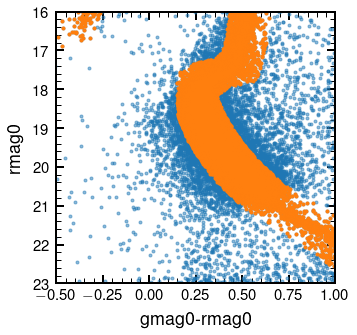

In [105]:
colorrange2 = cmd_selection(t, dm2, dotter_g, dotter_r)

ind= (t['dist2']<0.4) & (t['type'] == 'PSF') 
plt.plot(t['gmag0'][ind]-t['rmag0'][ind],t['rmag0'][ind],'.', alpha=0.5)

plt.plot(t['gmag0'][ind&colorrange2]-t['rmag0'][ind&colorrange2],t['rmag0'][ind&colorrange2], '.')

# plt.plot(dotter_g-dotter_r, dotter_r+dm2,lw=2,color='orange')
# plt.plot(dotter_g-dotter_r+grw, dotter_r+dm2,'--r')
# plt.plot(dotter_g-dotter_r-grw, dotter_r+dm2,'--r')
# plt.plot(dotter_g-dotter_r+grw, dotter_r+dm2+0.3,'--k')
# plt.plot(dotter_g-dotter_r-grw, dotter_r+dm2-0.3,'--k')
# plt.plot(dotter_g-dotter_r+grw, dotter_r+dm2-0.3,'--k')
# plt.plot(dotter_g-dotter_r-grw, dotter_r+dm2+0.3,'--k')

# plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm2, lw=2, color='orange')
# plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm2-0.4,'--k')
# plt.plot(des_m92_hb_g-des_m92_hb_r, des_m92_hb_r+dm2+0.4,'--k')
# plt.plot(des_m92_hb_g-des_m92_hb_r-0.1, des_m92_hb_r+dm2,'--r')
# plt.plot(des_m92_hb_g-des_m92_hb_r+0.1, des_m92_hb_r+dm2,'--r')


plt.ylim(23, 16)
plt.xlim(-0.5,1)
plt.ylabel('rmag0')
plt.xlabel('gmag0-rmag0')

Text(0.5, 0, 'ra')

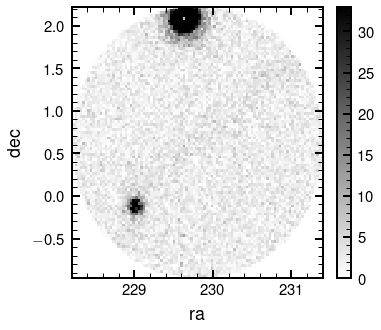

In [106]:
ind= (t['type'] == 'PSF') & (t['rmag']<22.5) & (t['rmag']>19) & (colorrange|colorrange2)
tvhist2d(t['ra'][ind],t['dec'][ind],bar=True, vmaxfrac=.99)
plt.ylabel('dec')
plt.xlabel('ra')

Text(0.5, 0, 'rmag')

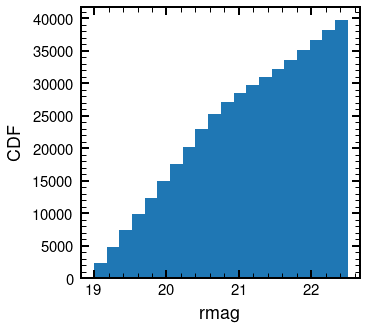

In [107]:
plt.hist(t['rmag'][ind],bins=20, cumulative=True)
plt.ylabel('CDF')
plt.xlabel('rmag')

Text(0.5, 0, 'ra')

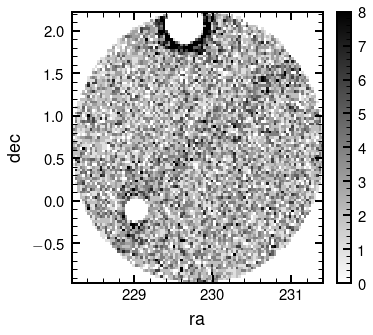

In [108]:
ind2 = (t['type'] == 'PSF') & (t['rmag']<22.5) & (t['rmag']>19) & (colorrange|colorrange2) & (t['dist1']>0.15) & (t['dist2']>0.25)
tvhist2d(t['ra'][ind2],t['dec'][ind2],bar=True, vmaxfrac=.99)
plt.ylabel('dec')
plt.xlabel('ra')

Text(0.5, 0, 'rmag')

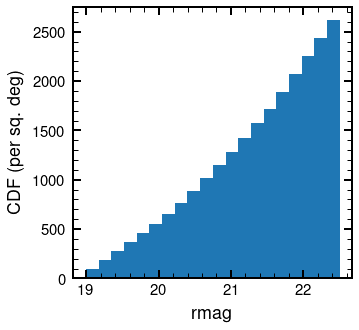

In [109]:
plt.hist(t['rmag'][ind2],bins=20, cumulative=True, weights=np.ones_like(t['rmag'][ind2])/(np.pi*rad0**2))
plt.ylabel('CDF (per sq. deg)')
plt.xlabel('rmag')

# To Dos
* add in proper motion and parallax information -- remove non members with large PM
* check distance gradient of the stream, select target based on distance
* select stars based on proper motion (optional)

In [110]:
sqlgaia = 'select source_id, ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error \
from gaia_edr3.gaia_source where q3c_radial_query(ra, dec, %f, %f, %f) and phot_g_mean_mag > 14'%(ra_cen,dec_cen, rad0)
gaia = sqlutilpy.get(sqlgaia, asDict = True)
gaia = table.Table(gaia)


In [111]:
t['idx'] = np.arange(len(t['ra']))

In [112]:
from astropy import table
from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=gaia['ra']*u.degree, dec=gaia['dec']*u.degree)
catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
match, d2d, d3d = c.match_to_catalog_sky(catalog)

In [164]:
plx_cut = gaia['parallax'] - 3 * gaia['parallax_error'] > 0.5 # distance > 2 kpc
pm_cut = (abs(gaia['pmra'])>5) | (abs(gaia['pmdec'])>5) # this will remove bright M5 members though

In [165]:
remove_list = t[match][(plx_cut|pm_cut)&(d2d<1*u.arcsec)]['idx']

In [166]:
ind2_gaiasel = np.array([i not in remove_list for i in t[ind2]['idx']])

Text(0.5, 0, 'rmag')

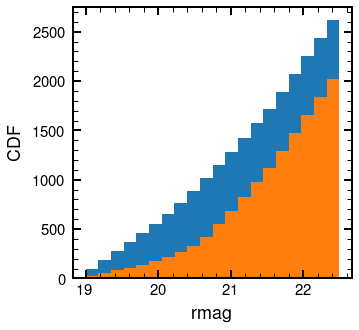

In [167]:
plt.hist(t['rmag'][ind2],bins=20, cumulative=True, weights=np.ones_like(t['rmag'][ind2])/(np.pi*rad0**2))
plt.hist(t['rmag'][ind2][ind2_gaiasel],bins=20, cumulative=True, weights=np.ones_like(t['rmag'][ind2][ind2_gaiasel])/(np.pi*rad0**2))
plt.ylabel('CDF')
plt.xlabel('rmag')

In [170]:
data = t

In [171]:
# Importing our libraries and packages required for the orbit
from galpy.orbit import Orbit
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
from galpy.util import conversion

# Importing potentials.
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential


In [172]:
## 6D Data and uncertainties from Dr. Andrew Pace's recent paper
sixD = [229.019, -0.121, 21.94,-2.7298,-2.6540,-58.61]
sigma = [0, 0, 0.51, 0.0278, 0.0272, 0.15]

pot = MWPotential2014
ro = 8.
vo = 220.
mo = conversion.mass_in_msol(ro=ro, vo=vo)
solarmotion = [-11.1, 12.24, 7.25]
# How many data points I want, taking into account the uncertainty
N_unc = 20
sixD_unc = np.random.normal(loc=sixD, scale=sigma, size = (N_unc,6))

In [173]:
# Initializing the orbits
o = Orbit(sixD, radec=True, solarmotion=solarmotion)
o_unc = Orbit(sixD_unc, radec=True, solarmotion=solarmotion)

In [174]:
# Initializing the timescale, so that I can integrate backwards 5Gyrs
t = 0.1
to = conversion.time_in_Gyr(ro=ro,vo=vo)
n = 101
ts= np.linspace(0.,-t/to,n)

(-0.9720215135552589, 2.226714148172068)

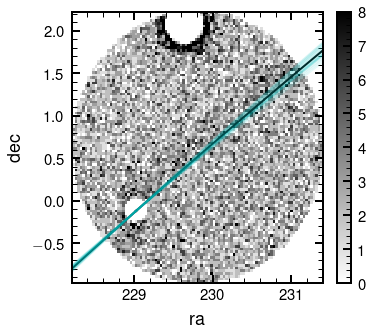

In [175]:
# Integrating the orbits
tvhist2d(data['ra'][ind2],data['dec'][ind2],bar=True, vmaxfrac=.99)
plt.ylabel('dec')
plt.xlabel('ra')

o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.dec(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.dec(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.dec(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.dec(-ts).T,'-c',alpha=0.1)
plt.xlim(data['ra'].min(), data['ra'].max())
plt.ylim(data['dec'].min(), data['dec'].max())

(20.94, 22.94)

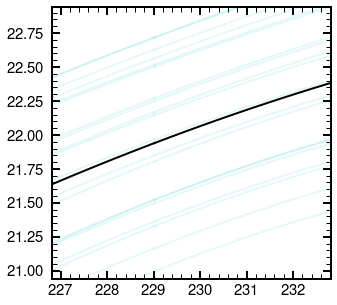

In [378]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.dist(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.dist(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.dist(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.dist(-ts).T,'-c',alpha=0.1)
plt.xlim(data['ra'].min(), data['ra'].max())
plt.ylim(dist-1, dist+1)

(226.80710629321416, 232.80694064027506)

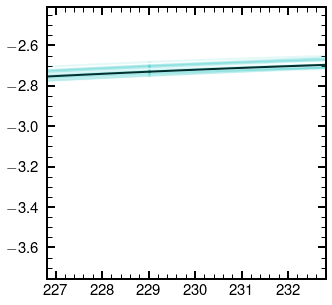

In [379]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.pmra(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.pmra(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.pmra(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.pmra(-ts).T,'-c',alpha=0.1)
plt.xlim(data['ra'].min(), data['ra'].max())
#plt.ylim(dist-1, dist+1)

(226.80710629321416, 232.80694064027506)

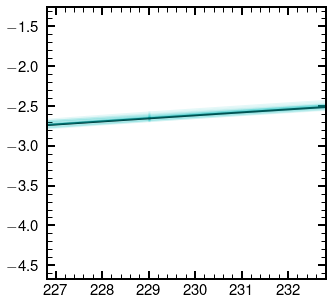

In [380]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)
plt.plot(o.ra(ts), o.pmdec(ts),'k')
plt.plot(o_unc.ra(ts).T,o_unc.pmdec(ts).T,'-c',alpha=0.1)

o.integrate(-ts, pot=pot)
o_unc.integrate(-ts, pot=pot)
plt.plot(o.ra(-ts), o.pmdec(-ts),'k')
plt.plot(o_unc.ra(-ts).T,o_unc.pmdec(-ts).T,'-c',alpha=0.1)
plt.xlim(data['ra'].min(), data['ra'].max())
#plt.ylim(dist-1, dist+1)